## adapted from: https://github.com/nzw0301/keras-examples/blob/master/CBoW.ipynb

In [35]:
import os,re,sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk

from nltk import word_tokenize
from nltk.corpus import stopwords as nltk_stopwords

import pickle
import string
import gensim

np.random.seed(42)

import keras.backend as K
from keras.models import Sequential,Model
from keras.layers import Embedding, Reshape, Activation, Input,Lambda, Dense, Concatenate, Average,Flatten
from keras.layers.merge import Dot
from keras.utils.data_utils import get_file
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

from collections import OrderedDict

from tqdm import *

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
src_dir = os.path.join(os.getcwd(), os.pardir, '../src')
sys.path.append(src_dir)

In [3]:
%aimport data.movielens_20m_imdb
%aimport utils.dataframes

from data.movielens_20m_imdb import load_or_get_from_cache
from utils.dataframes import sample_rows

In [4]:
VECTORS_DATA_ROOT = os.path.abspath("../../data/vectors/movielens-ml20m-imdb/")
INTERIM_DATA_ROOT = os.path.abspath("../../data/interim/movielens-ml20m-imdb/")
ML_ROOT = "/media/felipe/SAMSUNG/movielens/ml-20m/"
IMDB_ROOT = "/media/felipe/SAMSUNG/imdb/"

PATH_TO_SAVED_MODELS = os.path.abspath('../../models/')

PATH_TO_MOVIES = ML_ROOT + "/movies.csv"
PATH_TO_TAG_ASSIGNMENTS = ML_ROOT + "/tags.csv"
PATH_TO_MOVIE_PLOTS = IMDB_ROOT+"/plot.list"

In [5]:
MAX_TEXT_LENGTH = 500
NB_DOCS = 250
DIM = 50
CONTEXT_WINDOW_SIZE = 4
# STOPWORDS BREAK W2V!!!!
STOPWORDS = None

TOKENIZER_FILTERS = string.punctuation+"'"
NB_EPOCHS = 10

In [6]:
docs_df = load_or_get_from_cache(PATH_TO_MOVIES,PATH_TO_TAG_ASSIGNMENTS,PATH_TO_MOVIE_PLOTS,INTERIM_DATA_ROOT)

In [7]:
# remove this for production
docs_df = sample_rows(docs_df,NB_DOCS)

In [140]:
docs_df.sort_values('num_users',ascending=False).head(20)

,index,movie_id,title,unique_tags,num_users,num_unique_tags,plot
227,4878,68358,Star Trek (2009),"star-trek,time-travel,scifi,space,action,alter...",168.0,25,"On the day of James Kirk's birth, his father d..."
148,4237,48774,Children of Men (2006),"dystopia,apocalypse,atmospheric,scifi,survival...",144.0,25,The world's youngest citizen has just died at ...
82,535,1222,Full Metal Jacket (1987),"stanley-kubrick,vietnam-war,vietnam,antiwar,mi...",126.0,25,A two-segment look at the effect of the milita...
62,534,1219,Psycho (1960),"alfred-hitchcock,psychology,classic,suspensefu...",124.0,25,Phoenix officeworker Marion Crane is fed up wi...
189,4305,50872,Ratatouille (2007),"pixar,animation,cooking,disney,paris,rats,food...",114.0,25,A rat named Remy dreams of becoming a great Fr...
18,465,1036,Die Hard (1988),"bruce-willis,action,humorous,alan-rickman,chri...",108.0,25,NYPD cop John McClane goes on a Christmas vaca...
19,4219,48385,Borat: Cultural Learnings of America for Make ...,"satire,mockumentary,social-commentary,controve...",97.0,25,Borat Sagdiyev is a TV reporter of a popular s...
81,1330,3052,Dogma (1999),"satire,kevin-smith,religion,jay-and-silent-bob...",87.0,25,An abortion clinic worker with a special herit...
177,4376,53125,Pirates of the Caribbean: At World's End (2007),"johnny-depp,pirates,adventure,keira-knightley,...",79.0,25,"After Elizabeth, Will, and Captain Barbossa re..."
17,425,953,It's a Wonderful Life (1946),"christmas,classic,heartwarming,james-stewart,b...",74.0,25,George Bailey has spent his entire life giving...


In [11]:
corpus = docs_df['plot'].values

In [12]:
tokenizer = Tokenizer(filters=TOKENIZER_FILTERS)
tokenizer.fit_on_texts(corpus)

In [13]:
sequences = tokenizer.texts_to_sequences(corpus)

In [14]:
nb_samples = sum(len(seq) for seq in sequences)

In [15]:
# total size of the corpus, in words
# this will be the number of iterations be epoch
nb_samples

62430

In [16]:
# the document marker is just added as another word to every context
# note that it will be averaged with the other words in the context
def generate_data(document_sequences, window_size, vocabulary_size):
    
    maxlen = window_size*2
    
    for doc_index, word_sequence in enumerate(document_sequences):
                  
        text_length = len(word_sequence)
        
        for index_in_document,word in enumerate(word_sequence):
                  
            # these are the words in the context
            contexts = []
               
            # these are the target words (which we'll predict using the context)
            labels = []
        
            context_start = index_in_document - window_size           
            context_end   = index_in_document + window_size
            
            context_words = []
            
            for index_in_context in range(context_start, context_end+1):
                if index_in_document != index_in_context: # index_in_context is the target word
                    if index_in_context >= 0 and index_in_context < text_length: # inner_index must be a valid index
                        context_word = word_sequence[index_in_context]
                        context_words.append(context_word)
                                                                     
            labels.append(word)
                        
            x1 = sequence.pad_sequences([context_words], maxlen=maxlen)
                       
            # needs to be at least one or the index will be interpreted as a mask    
            x2 = np.array([doc_index+1])
                                   
            x = [x1,x2]
            
            y = np_utils.to_categorical(labels,vocabulary_size)           
            
#             print("contexts is: {}".format(contexts))
#             print("x1 is: {}".format(x1.shape))
#             print("x2 is: {}".format(x2.shape))
#             print("y is: {}".format(y.shape))
#             return
            
            yield (x,y) 

In [17]:
V = len(tokenizer.word_index)+1

input1 = Input(shape=(CONTEXT_WINDOW_SIZE*2,))
x1 = Embedding(V,output_dim=DIM,name="word_embeddings")(input1)
x1 = Flatten()(x1)

input2 = Input(shape=(1,))
x2 = Embedding(NB_DOCS+1,output_dim=DIM,name="document_embeddings")(input2)
x2 = Flatten()(x2)

x = Concatenate()([x1,x2])

outputs = Dense(V,activation='softmax')(x)

In [18]:
pvdm = Model(inputs=[input1,input2],outputs=outputs)
pvdm.compile(loss='categorical_crossentropy', optimizer='adadelta')

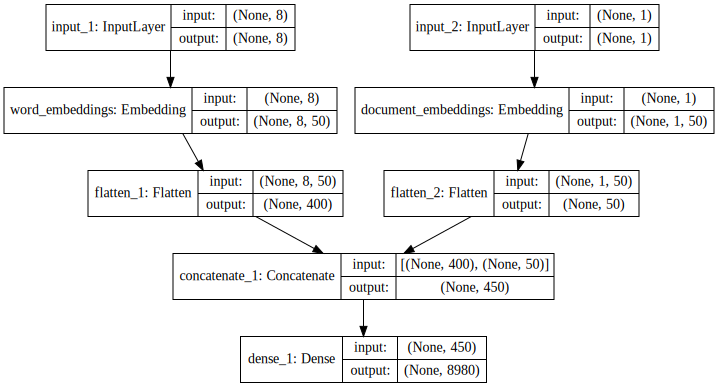

In [19]:
SVG(model_to_dot(pvdm,show_shapes=True).create(prog='dot', format='svg'))

In [20]:
avg_iter_second = 50
num_iterations = (nb_samples * NB_EPOCHS)

rough_time_in_hours = (num_iterations / avg_iter_second) / (60 * 60)
rough_time_in_hours

3.4683333333333333

In [ ]:
# xs = []
# ys = []

# for x, y in generate_data(document_sequences=sequences, window_size=CONTEXT_WINDOW_SIZE, vocabulary_size=len(tokenizer.word_index)+1):
#     xs.append(x)
#     ys.append(y)
# xs[0],ys[0],xs[1],ys[1],xs[2],xs[3],xs[4]

In [21]:
for epoch in range(NB_EPOCHS):
    loss = 0.
    for x, y in tqdm(generate_data(document_sequences=sequences, window_size=CONTEXT_WINDOW_SIZE, vocabulary_size=V)):
        
        loss += pvdm.train_on_batch(x, y)
    print(epoch, loss)

62430it [18:46, 57.17it/s]
6it [00:00, 59.02it/s]

0 497002.598744


62430it [18:00, 57.79it/s]
6it [00:00, 58.51it/s]

1 469230.909695


62430it [18:02, 57.69it/s]
6it [00:00, 58.41it/s]

2 467477.507672


62430it [17:48, 59.01it/s]
6it [00:00, 59.97it/s]

3 464970.633603


62430it [17:48, 58.45it/s]
6it [00:00, 59.65it/s]

4 462433.857839


62430it [17:50, 58.33it/s]
6it [00:00, 51.16it/s]

5 459878.768083


62430it [18:27, 56.40it/s]
6it [00:00, 55.48it/s]

6 457281.069936


62430it [18:18, 56.83it/s]
7it [00:00, 61.79it/s]

7 454490.672738


62430it [17:59, 57.83it/s]
6it [00:00, 58.42it/s]

8 452001.210965


62430it [18:00, 57.77it/s]

9 449520.108989


## save the model

In [28]:
path = PATH_TO_SAVED_MODELS+"/doc2vec-pvdm-model-{}.p".format(DIM)

In [29]:
pvdm.save(path)

## write word vectors

In [166]:
path_to_word_vectors_file = VECTORS_DATA_ROOT+'/doc2vec-pvdm-word-vectors-{}.txt'.format(DIM)
f = open(path_to_word_vectors_file ,'w')
f.write(' '.join([str(V-1), str(DIM)]))
f.write('\n')
word_embeddings =  pvdm.get_weights()[0]
for word, i in tokenizer.word_index.items():
    str_vec = ' '.join(map(str, list(word_embeddings[i, :])))
    f.write('{} {}\n'.format(word, str_vec))
f.close()

In [167]:
w2v = gensim.models.KeyedVectors.load_word2vec_format(path_to_word_vectors_file, binary=False)

In [169]:
w2v.most_similar(positive=['bad'])

[('beatrice', 0.7912397384643555),
 ('whose', 0.7872059941291809),
 ('unknown', 0.7792308926582336),
 ('ryan', 0.7753610610961914),
 ('steffi', 0.7629479169845581),
 ('throat', 0.75922691822052),
 ('joining', 0.7590861916542053),
 ('briegleb', 0.7498750686645508),
 ('rats', 0.7403017282485962),
 ('mrs', 0.7386329770088196)]

## write the document vectors

In [147]:
path_to_document_vectors_file = VECTORS_DATA_ROOT+'/doc2vec-pvdm-document-vectors-{}.txt'.format(DIM)
f = open(path_to_document_vectors_file ,'w')
f.write(' '.join([str(NB_DOCS), str(DIM)]))
f.write('\n')

1

In [161]:
# word_embeddings =  pvdm.get_weights()[0]
doc_embeddings = pvdm.get_weights()[1]

In [162]:
# one weight for the bias and another one for each document
doc_embeddings.shape

(8980, 50)

In [150]:
for i,document_id in enumerate(doc_embeddings):
    if i == 0:
        continue # bias
        
    # document_embedding i refers to document i-1
    
    document_title = docs_df.iloc[i-1]['title']
    document_vector = doc_embeddings[i]
    
    f.write(str(i))
    f.write(' ')
    f.write(' '.join(map(str, list(document_vector))))
    f.write('\n')
f.close()

In [151]:
f.close()

## let's see if the pseudo_documents are good representations for the documents.

One way to find this is to fetch the most similar documents to a given document￼

In [152]:
gensim_model = gensim.models.KeyedVectors.load_word2vec_format(path_to_document_vectors_file, binary=False)

In [153]:
def get_title(document_index, source_dataframe):
    return source_dataframe.iloc[document_index]['title']

In [154]:
def get_tags(document_index, source_dataframe):
    return ','.join(source_dataframe.iloc[document_index]['unique_tags'].split(',')[:4])

In [155]:
def most_similar(document_index,source_dataframe,gensim_w2v_model):
    tuples = gensim_w2v_model.most_similar(positive=[str(document_index+1)])
    
    print("title for source document is: {}".format(get_title(document_index, source_dataframe)))
    
    return [ (index, get_title(int(index),source_dataframe), similarity) for index,similarity in tuples ]    

In [156]:
most_similar(227,docs_df,gensim_model)

title for source document is: Star Trek (2009)


[('218', 'Severance (2006)', 0.7563555836677551),
 ('79', 'Jeffrey (1995)', 0.7415332198143005),
 ('213', 'Jagged Edge (1985)', 0.7302216291427612),
 ('62', 'Psycho (1960)', 0.7292182445526123),
 ('83', 'Eyes of Laura Mars (1978)', 0.7071167826652527),
 ('65', 'Coldblooded (1995)', 0.681449294090271),
 ('59', 'Rising Sun (1993)', 0.6784266233444214),
 ('245',
  'Prison Terminal: The Last Days of Private Jack Hall (2013)',
  0.674137532711029),
 ('229', 'Team America: World Police (2004)', 0.6681739687919617),
 ('15', 'Princesas (2005)', 0.6669789552688599)]

In [157]:
most_similar(62,docs_df,gensim_model)

title for source document is: Psycho (1960)


[('248', 'From the Journals of Jean Seberg (1995)', 0.7716283202171326),
 ('132',
  'Cameraman: The Life and Work of Jack Cardiff (2010)',
  0.7481696605682373),
 ('127', 'Fatal Beauty (1987)', 0.7336030006408691),
 ('84', 'Gordy (1995)', 0.7163759469985962),
 ('91',
  'Once in a Lifetime: The Extraordinary Story of the New York Cosmos (2006)',
  0.6946930885314941),
 ('202', 'Limbo (1999)', 0.6826401948928833),
 ('235', 'Key Largo (1948)', 0.6813738346099854),
 ('196', 'Charly (2002)', 0.650294303894043),
 ('209', 'Grease (1978)', 0.6348586082458496),
 ('57', 'Carrie (1952)', 0.6332916021347046)]

In [160]:
most_similar(248,docs_df,gensim_model)

title for source document is: From the Journals of Jean Seberg (1995)


[('223', 'Ikiru (1952)', 0.8042960166931152),
 ('161', 'Zero Effect (1998)', 0.7805737257003784),
 ('44', 'Click (2006)', 0.7766533493995667),
 ('29', 'Billy Bathgate (1991)', 0.7697432041168213),
 ('101', 'Sayonara (1957)', 0.7638599276542664),
 ('214', 'Mirage (1965)', 0.7635664343833923),
 ('16', 'Local Hero (1983)', 0.7534139156341553),
 ('78', 'My Winnipeg (2007)', 0.7447584867477417),
 ('183', '7 Khoon Maaf (2011)', 0.7432988286018372),
 ('213', 'Jagged Edge (1985)', 0.7400705218315125)]

In [ ]:
w2v.most_similar(positive=['can'])